# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第14节 量化相关性分析应用</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

交易目标之间的相关性分析是量化交易中一个非常重要的工具，本节将示例abupy中相关分析模块的使用示例：

首先导入abupy中本节使用的模块：

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


In [2]:
from abupy import abu, ml, nd, tl, ECoreCorrType, ABuSymbolPd, ABuScalerUtil, AbuFuturesCn, ABuCorrcoef
from abupy import find_similar_with_cnt, find_similar_with_se, find_similar_with_folds
from abupy import EMarketTargetType, ABuStatsUtil, ABuSimilar, ABuIndustries

受限于沙盒中数据限制，本节示例的相关性分析只限制在abupy内置沙盒数据中，首先将内置沙盒中美股，A股，港股, 比特币，莱特币，期货市场中的symbol都列出来:

In [3]:
us_choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG', 'usWUBA', 'usVIPS', 'us.IXIC']
cn_choice_symbols = ['002230', '300104', '300059', '601766', '600085', '600036', '600809', '000002', '002594', '002739', 'sh000001']
hk_choice_symbols = ['hk03333', 'hk00700', 'hk02333', 'hk01359', 'hk00656', 'hk03888', 'hk02318', 'hkHSI']
tc_choice_symbols = ['btc', 'ltc']
# 期货市场的直接从AbuFuturesCn().symbo中读取
ft_choice_symbols = AbuFuturesCn().symbol.tolist()

all_choice_symbols = us_choice_symbols + cn_choice_symbols + hk_choice_symbols + tc_choice_symbols +ft_choice_symbols
len(all_choice_symbols)

75

如上所示abupy内置沙盒中的symbol共75个，下面组装这75个symbol形成一个三维panel数据，摘取所有数据的p_change(涨跌幅)列形成二维dataframe对象，如下所示：

In [4]:
panel = ABuSymbolPd.make_kl_df(all_choice_symbols, start='2015-07-27', end='2016-07-26',
                               show_progress=True)
# 转换panel轴方向，即可方便获取所有金融时间数据的某一个列
panel = panel.swapaxes('items', 'minor')
net_cg_df = panel['p_change'].fillna(value=0)
net_cg_df.head()

pid:72371 _make_kl_df complete:100.0%
pid:72371 done!


,000002,002230,002594,002739,300059,300104,600036,600085,600809,601766,...,sh000001,us.IXIC,usAAPL,usBIDU,usGOOG,usNOAH,usSFUN,usTSLA,usVIPS,usWUBA
2015-07-27,-8.237,-10.036,-10.069,-6.714,-10.054,-10.012,-7.286,-10.073,-10.487,-10.154,...,-8.483,-0.96,-1.39,-4.16,0.59,-5.30,-5.72,-4.67,-1.28,-3.62
2015-07-28,3.116,-3.422,-0.463,0.663,-9.605,-4.211,2.227,2.240,1.435,-5.841,...,-1.679,0.98,0.50,-15.00,0.12,3.52,0.00,4.67,1.05,-4.09
2015-07-29,-0.144,7.980,10.075,-0.931,10.014,10.019,0.769,5.963,6.305,6.406,...,3.444,0.44,-0.32,1.18,0.63,1.79,0.44,-0.38,0.30,-0.71
2015-07-30,-3.746,-5.711,-5.477,-9.505,-3.590,-2.103,-1.144,-1.356,-5.155,-4.246,...,-2.201,0.33,-0.50,2.62,0.10,-2.06,-2.06,1.13,-2.76,0.58
2015-07-31,0.749,1.589,7.389,-9.706,1.241,6.251,2.058,1.718,3.098,0.000,...,-1.134,-0.01,-0.87,-1.04,-1.10,-0.09,0.30,-0.24,-1.07,-1.41


### 1. 相关相似度的度量

机器学习与比特币示例章节通过比特币的数据特征组成了学习数据，通过训练数据来决策是否有大波动，对于机器学习来说获取更多特征，更多数据始终是优化的最重要且最有效的手段，如果你需要从其它市场找到和比特币有相关性的品种，变换形成新的特征，最简单的方法可以使用corr_xy接口：

In [5]:
ABuCorrcoef.corr_xy(net_cg_df.btc, net_cg_df['601766'], similar_type=ECoreCorrType.E_CORE_TYPE_PEARS)

-0.048279527947480187

上面通过默认参数获取601766与比特币的相关度，数值为-0.04，可以通过关键子参数similar_type来切换相关的计算方法，如下使用E_CORE_TYPE_SPERM：

In [6]:
ABuCorrcoef.corr_xy(net_cg_df.btc, net_cg_df['601766'], similar_type=ECoreCorrType.E_CORE_TYPE_SPERM)

-0.097886272084964976

下面使用E_CORE_TYPE_SIGN，sign的相关度度量，只关注符号，不关心具体数据，即比如今天比特币涨，那只要601766今天也涨就正相关，不会理会具体涨多少，实际上这种度量方式更适合交易类型产品：

In [7]:
ABuCorrcoef.corr_xy(net_cg_df.btc, net_cg_df['601766'], similar_type=ECoreCorrType.E_CORE_TYPE_SIGN)

-0.067025116921873129

下面使用时间加权相关E_CORE_TYPE_ROLLING，进行计算，即时间上越早的相关值所占权重越小，时间上越晚的相关值权重越大：

In [8]:
ABuCorrcoef.corr_xy(net_cg_df.btc, net_cg_df['601766'], similar_type=ECoreCorrType.E_CORE_TYPE_ROLLING)

rolling_corr cost 0.011s


-0.098124897642975412

上面的corr_xy的接口参数只能是两个品种的相关度度量，如果想要从上面net_cg_df的75种品种中找到与比特币最相关的品种很麻烦，使用corr_matrix接口可以一次输出计算：

In [9]:
corr_df = ABuCorrcoef.corr_matrix(net_cg_df, )
corr_df.btc.sort_values()[::-1][:10]

btc       1.0000
ltc       0.7649
usTSLA    0.0991
000002    0.0877
B0        0.0853
002594    0.0816
AL0       0.0798
P0        0.0717
SR0       0.0709
AG0       0.0691
Name: btc, dtype: float64

corr_matrix接口同样支持关键字参数similar_type，如下使用E_CORE_TYPE_SIGN：

In [10]:
corr_df = ABuCorrcoef.corr_matrix(net_cg_df, similar_type=ECoreCorrType.E_CORE_TYPE_SIGN)
corr_df.btc.sort_values()[::-1][:10]

btc       1.0000
ltc       0.7176
FB0       0.0852
usAAPL    0.0786
RS0       0.0676
000002    0.0645
BB0       0.0601
RI0       0.0599
usSFUN    0.0558
FU0       0.0483
Name: btc, dtype: float64

上面输出的都是正相关的top10，发现除了ltc（莱特币）外，其它的相关度也都在0附近，都没有超过0.1，即都基本无关，实际上不管是正相关还是负相关都成为可以有用的素材，下面看一下时间加权相关的top10负相关的品种：

In [11]:
corr_df = ABuCorrcoef.corr_matrix(net_cg_df, ECoreCorrType.E_CORE_TYPE_ROLLING)
corr_df.btc.sort_values()[:10]

rolling_corr cost 0.147s


hk01359    -0.1803
hk02318    -0.1600
hkHSI      -0.1281
V0         -0.1254
300059     -0.1083
601766     -0.0981
hk00656    -0.0919
hk03888    -0.0857
us.IXIC    -0.0779
sh000001   -0.0697
Name: btc, dtype: float64

如上所示负相关的数值有几个已经上到0.1以上了，但是由于沙盒数据中的交易品种所限，并没有找到适合构成特征（强正相关，或者强负相关）的品种。

备注：之后的章节在使用非沙盒数据的前提下，会编写在完整的各个全市场中寻找与比特币最强正相关，最强负相关的示例，以及通过它们构成特征，实现策略的优化

### 2. 距离的度量与相似度

与相似度度量相反的是两个矢量之间距离的度量，如下示例在abupy中的距离度量接口使用：

In [12]:
ABuStatsUtil.euclidean_distance_xy(net_cg_df.btc, net_cg_df.ltc)

51.878666694509434

上面的接口度量了比特币和莱特币之间的欧式距离(L2范数)，下面度量曼哈顿距离(L1范数)：

In [13]:
ABuStatsUtil.manhattan_distances_xy(net_cg_df.btc, net_cg_df.ltc)

537.47800000000052

下面度量余弦距离：

In [14]:
ABuStatsUtil.cosine_distances_xy(net_cg_df.btc, net_cg_df.ltc)

0.23673712776004519

上面接口cosine_distances_xy度量了比特币和莱特币之间的余弦距离，0.23为距离的度量值，距离和相似度之间可以通过关键字参数to_similar=True将余弦距离直接转换为余弦相似度，如下所示：

In [15]:
ABuStatsUtil.cosine_distances_xy(net_cg_df.btc, net_cg_df.ltc, to_similar=True)

0.76326287223995481

和相似度接口类似，xy接口只能两个直接度量，通过matrix接口可实现矩阵的度量，如下所示：

In [16]:
euclidean_df = ABuStatsUtil.euclidean_distance_matrix(net_cg_df)
euclidean_df.btc.sort_values()[:10]

btc    0.0000
ltc    0.4318
WH0    0.5554
AL0    0.5571
AU0    0.5614
SR0    0.5621
PB0    0.5641
AG0    0.5644
CU0    0.5650
A0     0.5672
Name: btc, dtype: float64

可以看到与比特币距离最短的是莱特币，同时可以通to_similar=True将距离度量值转换为相似度，如下所示：

In [17]:
manhattan_df = ABuStatsUtil.euclidean_distance_matrix(net_cg_df, to_similar=True)
manhattan_df.btc.sort_values()[::-1][:10]

btc    1.0000
ltc    0.5682
WH0    0.4446
AL0    0.4429
AU0    0.4386
SR0    0.4379
PB0    0.4359
AG0    0.4356
CU0    0.4350
A0     0.4328
Name: btc, dtype: float64

上面度量了欧式距离(L2范数)，下面度量曼哈顿距离(L1范数)的matrix接口：

In [18]:
manhattan_df = ABuStatsUtil.manhattan_distance_matrix(net_cg_df, to_similar=True)
manhattan_df.btc.median()

0.37316382510050927

上面度量结果的中位数，值为0.37，很高，因为L1范数和L2范数针对相似度的度量只是相对的，只在数据范围内，数据之间进行数据比较统计的意义不大，如上ltc的值和WHO差不多大，余弦距离与它们不同，如下示例，可以看到ltc与usTSLA数值差别很大：

In [19]:
cosine_df = ABuStatsUtil.cosine_distance_matrix(net_cg_df, to_similar=True)
cosine_df.btc.sort_values()[::-1][:10]

btc       1.0000
ltc       0.8213
usTSLA    0.3191
000002    0.3130
B0        0.3129
002594    0.3077
AL0       0.3051
AG0       0.3021
SR0       0.3018
P0        0.2995
Name: btc, dtype: float64

备注：与上述接口的使用类似，通过ABuScalerUtil.scaler_xy针对两组矢量进行标准化，通过ABuScalerUtil.scaler_matrix针对矩阵进行标准化。

### 3. 相似相关接口的应用

下面示例在abupy中相关相似上层封装的接口的使用，如下通过将市场设置为通过E_MARKET_TARGET_CN，获取A股全市场数据与600036进行对比，可视化最相关的top10个：

备注：由于使用的是沙盒数据，所以市场中本身数据就只有几个，如果在非沙盒环境下，将从市场中几千个symbol中度量相关性：

[('600036', 1.0), ('600085', 0.18746310519070053), ('601766', 0.16092010174236029), ('000002', 0.15201946573417266), ('002594', 0.090141541940086695), ('600809', 0.08546095455608782), ('300059', 0.058106113286564912), ('300104', 0.040346982734044065), ('002230', 0.039347445604041603), ('002739', -0.025313117068593773)]


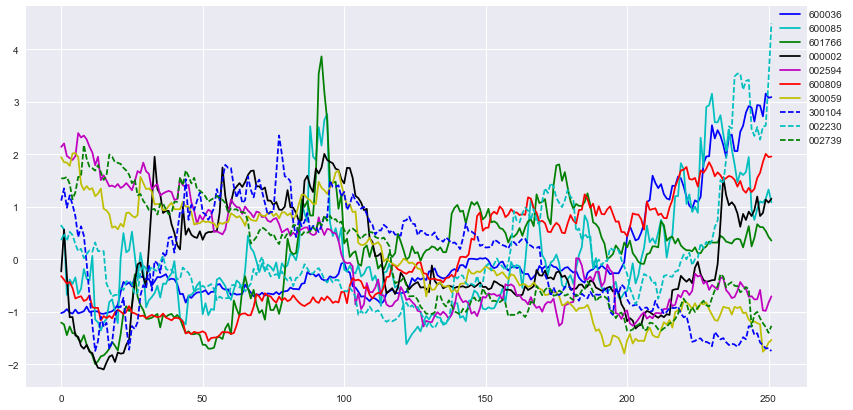

In [20]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN
similar_dict = find_similar_with_cnt('600036', 252)

上面的接口使用的是find_similar_with_cnt，参数252为天数，即度量最近一年的相关性，下面切换市场为港股市场，接口使用find_similar_with_se参数通过start，end进行设置时间，关键字参数corr_type代表度量相关算法，使用查看hk02333与港股市场的相关性：

[('hk02333', 1.0), ('hk00656', 0.24601704763153207), ('hk01359', 0.24203066017997449), ('hk02318', 0.23406013646744359), ('hk00700', 0.13924584542259066), ('hk03333', 0.11687041715770088), ('hk03888', 0.033580672103364573)]


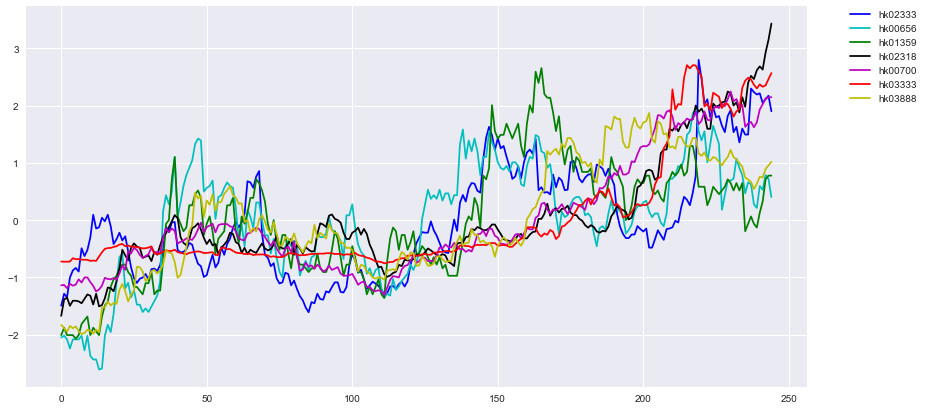

In [21]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_HK
_ = find_similar_with_se('hk02333', start='2016-07-26', end='2017-07-26', corr_type=ECoreCorrType.E_CORE_TYPE_PEARS)

下面的市场继续在港股市场，但参数symbol使用比特币，即度量的结果为比特币与港股市场的相关性：

[('btc', 1.0), ('hk03333', 0.087948053966186684), ('hk02318', 0.057208549474234399), ('hk00700', 0.027568472278148865), ('hk01359', 0.0047700609238161343), ('hk03888', -0.010501786826757909), ('hk00656', -0.032787443726602972), ('hk02333', -0.086537956413257899)]


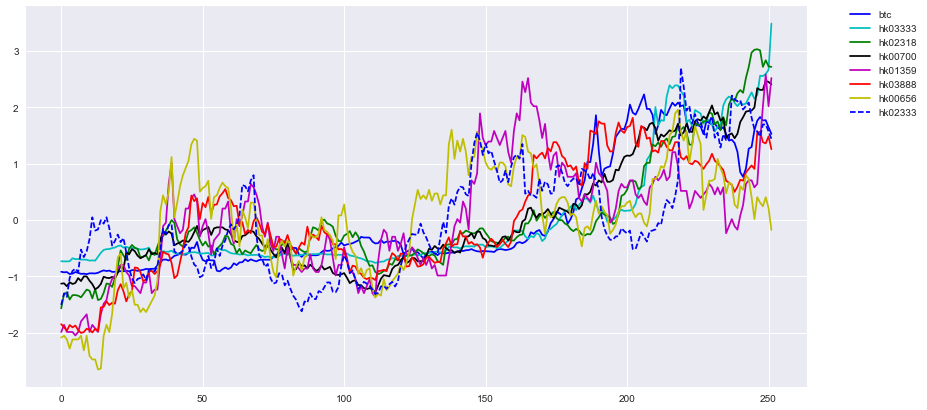

In [22]:
_ = find_similar_with_cnt('btc', 252, corr_type=ECoreCorrType.E_CORE_TYPE_PEARS)

下面的市场继续在港股市场，但接口使用find_similar_with_folds，参数参数n_folds代表年数，symbol使用比特币，corr_type使用时间加权相关度量，如下所示：

[('btc', 0.999999999999999), ('hk00700', 0.10763164865060315), ('hk02318', 0.10660013960666159), ('hk03333', 0.074239098008015258), ('hk01359', 0.046902811046481439), ('hk03888', 0.024748563207458382), ('hk00656', -0.024429750776305867), ('hk02333', -0.056443723857550823)]


rolling_corr cost 0.095s


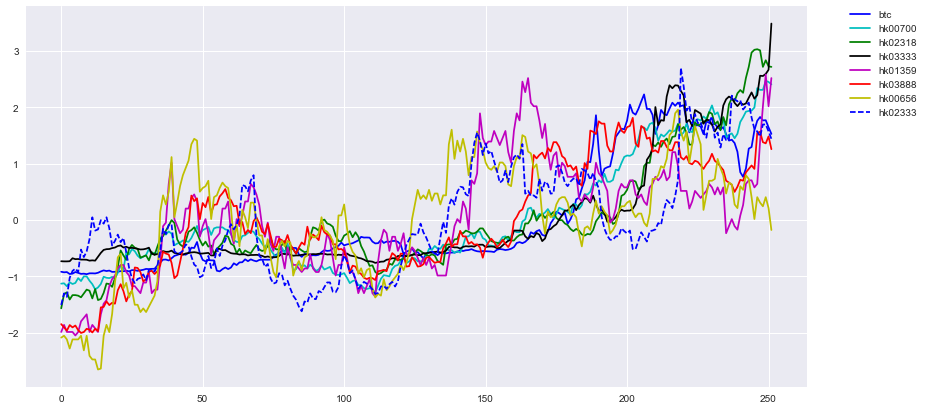

In [23]:
_ = find_similar_with_folds('btc', n_folds=1, corr_type=ECoreCorrType.E_CORE_TYPE_ROLLING)

上面的接口通过corr_type来切好相关度度量算法，如果想使用多种度量算法，同时度量，可以使用calc_similar接口，使用如下所示：

In [25]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN
rank_score, _ = tl.similar.calc_similar('600036', '601766', corr_jobs=(ECoreCorrType.E_CORE_TYPE_PEARS,
                                                                              ECoreCorrType.E_CORE_TYPE_SPERM), show=False)
rank_score

0.7272727272727273

上面使用E_CORE_TYPE_PEARS和E_CORE_TYPE_SPERM共同做为度量算法，下面使用+-号相关和时间加权相关，如下所示：

In [29]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN
rank_score, _ = tl.similar.calc_similar('600036', '601766', corr_jobs=(ECoreCorrType.E_CORE_TYPE_ROLLING, ECoreCorrType.E_CORE_TYPE_ROLLING), show=False)
rank_score

0.6363636363636364

观察上面的输出值都很高，通过corr_xy度量两支股票的相关度只有0.458，如下所示：

In [30]:
ABuCorrcoef.corr_xy(net_cg_df['600036'], net_cg_df['601766'])

0.45800040483852272

实际上ABuTLSimilar.calc_similar()度量的是两支股票相对整个市场的相关性评级，它不关心某一个股票具体相关性的数值的大小，calc_similar(a, b) 的工作流程如下：

1. 计算a与市场中所有股票的相关性
2. 将所有相关性进行rank排序
3. 查询股票b在rank序列中的位置，此位置值即为结果

即ABuTLSimilar.calc_similar返回值由0至1，这样的好处是通过计算600036与601766在所有股票中的相似度水平，会更全局客观的体现相关性。

下面calc_similar的show=True进行可视化，它可视化了两支股票的价格距离，如下所示：

pid:72371 _make_kl_df complete:100.0%
pid:72371 done!


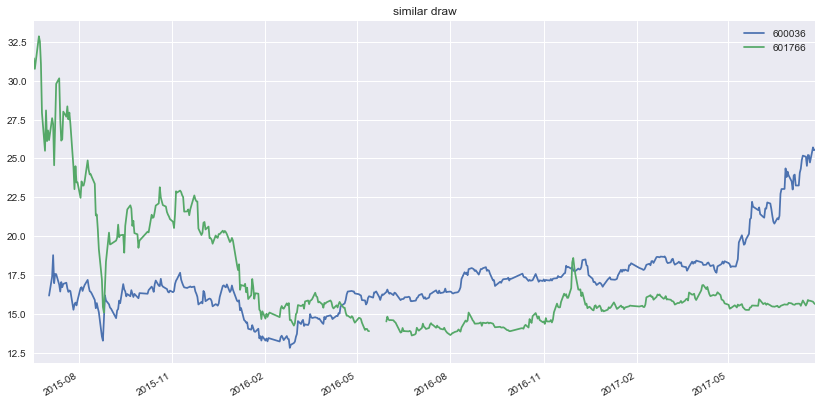

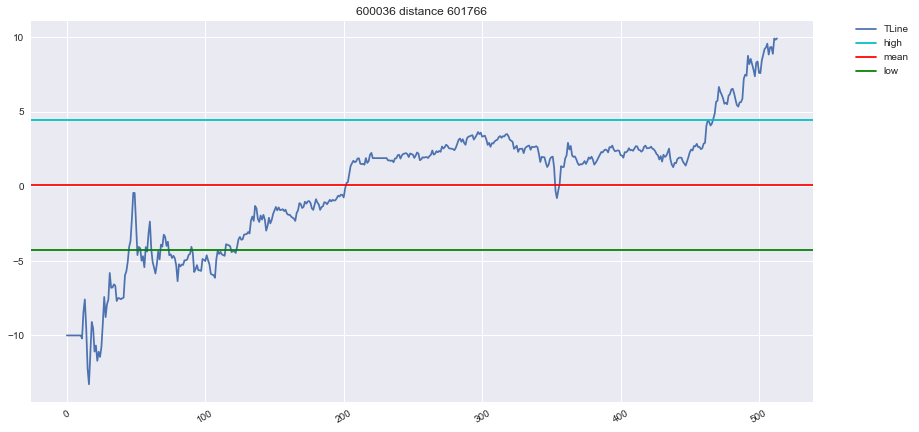

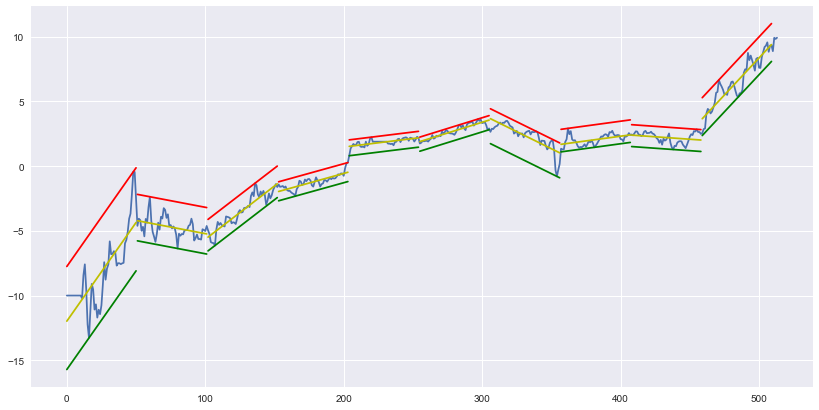

In [31]:
rank_score, _ = tl.similar.calc_similar('600036', '601766', show=True)

### 4. 自然相关性

上面说的相关性都是通过走势数值计算度量出的相关性，在股票市场中存在另一种自然相关性，即行业分类的相关。

如下示例abupy中行业分类的相关api，首先从市场中找到与600036处在一个行业中的所有股票，返回dataframe对象，返回中有公司的一些基本信息和财务数据：

In [52]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
# 找到与600036处在一个行业中的所有股票, 返回dataframe对象
industries, _ = ABuIndustries.industries_df('600036')
# 输出显示后5个股票信息
industries.tail()

,name,symbol,market,每股净资产：,业务:,流通股本：,振幅：,市盈率(静)/(动)：,简介:,exchange,总市值：,市净率(动)：,市销率(动)：,总股本：,industry,industry_factorize
3852,招商银行,600036,SH,16.68,-,206.29亿,3.30%,8.90/8.67,本行是经中国人民银行银复(1986)175号文、银复(1987)86号文批准成立的商...,SH,5525.67亿,1.31,2.65,252.20亿,银行,29
3946,吴江银行,603323,SH,7.12,-,1.12亿,8.83%,27.60/26.96,"2004年8月12日,中国银监会下发《关于江苏吴江农村商业银行股份有限公司开业的批复...",SH,179.45亿,2.26,7.05,11.14亿,银行,29
4024,常熟银行,601128,SH,4.55,-,2.22亿,6.02%,25.29/24.52,江苏常熟农村商业银行股份有限公司前身为成立于1996年的原常熟市农村信用合作社联合社...,SH,263.17亿,2.60,5.42,22.23亿,银行,29
4090,江阴银行,002807,SZ,5.00,-,2.09亿,4.74%,29.63/29.70,"公司前身成立于2001年12月3日,成立时的注册名称为""江阴市农村商业银行股份有限公...",SZ,230.46亿,2.61,9.39,17.67亿,银行,29
4105,张家港行,002839,SZ,4.52,-,1.81亿,6.62%,43.75/43.75,"2001年11月26日,中国人民银行批准张家港市农村商业银行股份有限公司开业,并核发...",SZ,301.68亿,3.69,12.00,18.08亿,银行,29


自然相关性来自人为的对行业进行分类，可以通过industries_factorize获取某个市场中所有行业分类信息，如下获取港股市场中所有行业：

In [44]:
ABuIndustries.industries_factorize(market=EMarketTargetType.E_MARKET_TARGET_HK)

0     电子商贸及互联网服务
1        电讯及网络器材
2              -
3           其他零售
4      软件及资讯科技顾问
5          纺织及成衣
6          赌场与赌博
7        电器部件及设备
8        家居耐用消费品
9          中国房地产
10         电子消费品
11      饮品 (酒精类)
12     煤炭开采及相关贸易
13            制药
14          百货公司
15     医疗保健设备及用品
16     金属采矿及相关贸易
17       工业机械及设备
18          美容护肤
19          影视娱乐
20           农产品
21      造纸、印刷及包装
22        其他金融服务
23    石油/燃气设备及服务
24          地产投资
25          综合科技
26     投资控股及资产管理
27        电力公用事业
28       环保产品及服务
29        综合化工产品
30       个人及家居用品
31        综合支援服务
32            海运
33            食肆
34       交易所买卖基金
35            林业
36            广告
37          钟表珠宝
38            建筑
39       成衣及服饰零售
40        环保公用事业
41          综合地产
42          航空服务
43     消费信贷及贷款融资
44          综合企业
45            --
46       电脑及周边产品
47        证券及经纪业
48          汽车零售
49          铁路基建
50            汽车
51            出版
52            玩具
53         海港与服务
54       包装食品与肉类
55          电讯服务
56        燃气公用事业
57         水公用事业
58            

如果你对上面行业分类中的序号6:赌场与赌博，序号9:中国房地产，比较感兴趣，可以使用如下方式查询这两个行业中的所有股票信息：

In [56]:
# 6:赌场与赌博，序号9:中国房地产 只显示后5支股票信息
ABuIndustries.query_factorize_industry_df([6, 9], market=EMarketTargetType.E_MARKET_TARGET_HK).tail()

,name,symbol,market,每股净资产：,业务:,振幅：,市盈率(静)/(动)：,简介:,空头补回天数：,港股股本：,exchange,总市值：,市盈率(静)：,市净率(动)：,总股本：,市销率：,industry,换手率：,机构持股：,市净率MRQ：,industry_factorize
1998,御泰中彩控股,00555,HK,0.54,-,-,-,御泰中彩控股有限公司是一家在香港联合交易所主板上市的公司(股份代号:555)。本集团...,-,100.28亿,HK,11.93亿,-,0.22,100.28亿,0.95,赌场与赌博,0.53%,-,-,6
2043,金界控股,03918,HK,3.96,-,-,-,-,-,24.60亿,HK,99.14亿,6.9589,1.02,24.60亿,2.39,赌场与赌博,0.09%,-,-,6
2207,汇彩控股,01180,HK,0.53,-,-,-,滙彩控股於亚太区提供娱乐场游戏、经营真人派牌电子桌上游戏终端机及累计奖金彩池(专利申...,-,10.52亿,HK,12.31亿,-,2.22,10.52亿,1.06,赌场与赌博,0.01%,-,-,6
2228,结好控股,00064,HK,0.58,-,-,-,结好集团於一九八八年成立。集团最早成立之公司为结好投资有限公司( 现称「结好证券有限...,-,80.52亿,HK,22.55亿,4.8621,0.48,80.52亿,4.53,赌场与赌博,0.03%,-,-,6
2405,医汇集团,08161,HK,0.08,-,-,-,"我们在香港营运超过20年。於最後实际可行日期,我们共有十名注册牙医及三名牙齿卫生员在...",-,10.40亿,HK,2.96亿,-,3.65,10.40亿,2.85,赌场与赌博,1.17%,-,-,6


如果你在回测中想使用比如上面两个分类中的所有股票进行回测，可以使用如下接口获取行业中所有股票symbol序列：

In [57]:
ABuIndustries.query_factorize_industry_symbol([6, 9], market=EMarketTargetType.E_MARKET_TARGET_HK)[:5]

['hk00149', 'hk02007', 'hk00123', 'hk00272', 'hk00119']

如果已经有了想要查询的具体行业目标，比如想要从A股市场中模糊查询医学相关的股票，可以使用如下接口：

In [61]:
# 从A股市场中查询医学相关的股票显示前5个
ABuIndustries.query_match_industries_df('医学', market=EMarketTargetType.E_MARKET_TARGET_CN).head()

,name,symbol,market,每股净资产：,业务:,流通股本：,振幅：,市盈率(静)/(动)：,简介:,exchange,总市值：,市净率(动)：,市销率(动)：,总股本：,industry,industry_factorize
18,易明医药,002826,SZ,2.96,-,4743.00万,4.29%,68.20/68.20,"2007年12月29日,公司前身西藏雪山金罗汉医药有限公司成立。\n 2009...",SZ,37.75亿,6.73,7.90,1.90亿,医药生物,9
47,中源协和,600645,SH,3.96,-,3.54亿,3.85%,205.90/108.68,"本公司原名上海望春花(集团)股份有限公司,系1992年5月5日经上海市人民政经济委员...",SH,77.95亿,5.10,8.71,3.86亿,医药生物,9
66,陇神戎发,300534,SZ,8.21,-,7584.50万,9.13%,138.67/146.96,"甘肃陇神戎发制药有限公司于2002年6月3日正式成立,它的前身是兰州军区军事医学研究...",SZ,65.52亿,2.63,24.45,3.03亿,医药生物,9
103,金花股份,600080,SH,3.53,-,3.05亿,4.36%,105.46/95.40,金花企业(集团)股份有限公司是经陕西省人民政府办公厅陕改办函(1996)23号<关于...,SH,28.79亿,2.67,4.13,3.05亿,医药生物,9
117,欧普康视,300595,SZ,5.72,-,3060.00万,5.49%,57.48/53.75,"公司前身欧普康视科技(合肥)有限公司于2000年10月26日,由美国奥泰克公司投资设...",SZ,65.55亿,9.36,26.38,1.22亿,医药生物,9


如果从A股市场中模糊查询医学相关所有股票进行回测，可以使用如下接口获取行业中所有股票symbol序列：

In [50]:
ABuIndustries.query_match_industries_symbol('医学', market=EMarketTargetType.E_MARKET_TARGET_CN)[:5]

['sz002826', 'sh600645', 'sz300534', 'sh600080', 'sz300595']

小节：

* 本节主要讲解的都是相关接口在abupy中的使用示例，更多理论以及基础请阅读《量化交易之路》中的相关内容。
* 完整的应用相关性进行择时选股的策略在之后的章节会陆续进行示例，请关注公众号的更新提醒

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)